### Install Dependencies

In [123]:
! pip install qiskit_optimization
! pip install pylatexenc
! pip install dwave-ocean-sdk
! pip install gurobipy

### Import Dependencies

In [7]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
from qiskit_optimization.applications import Maxcut
import dimod
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite


In [ ]:
# Importing functions from the modules in the qseg package
from qseg.graph_utils import image_to_grid_graph, draw
from qseg.dwave_utils import dwave_solver, annealer_solver
from qseg.utils import decode_binary_string

# Additional necessary imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qiskit_optimization.applications import Maxcut
import dimod
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite


### Functions

In [126]:
def image_to_grid_graph(gray_img, sigma=0.5):
  h, w = gray_img.shape
  nodes = np.zeros((h*w, 1))
  edges = []
  nx_elist = []
  min_weight = 1
  max_weight = 0
  for i in range(h*w):
    x, y = i//w, i%w
    nodes[i] = gray_img[x,y]
    if x > 0:
      j = (x-1)*w + y
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x-1,y])**2) / (2 * sigma**2))      # Gaussian similarity
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x-1,y),np.round(weight,2)))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
    if y > 0:
      j = x*w + y-1
      weight = 1-np.exp(-((gray_img[x,y] - gray_img[x,y-1])**2) / (2 * sigma**2))      # Gaussian similarity
      edges.append((i, j, weight))
      nx_elist.append(((x,y),(x,y-1),weight))
      if min_weight>weight:min_weight=weight
      if max_weight<weight:max_weight=weight
  a=-1
  b=1
  if max_weight-min_weight:
    normalized_edges = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,4)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(((b-a)*((edge_weight-min_weight)/(max_weight-min_weight)))+a,4)) for node1,node2,edge_weight in nx_elist]
  elif max_weight==0 and min_weight==0:
    normalized_edges = [(node1,node2,1) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,1) for node1,node2,edge_weight in nx_elist]
  else:
    normalized_edges = [(node1,node2,-1*np.round(edge_weight,4)) for node1,node2,edge_weight in edges]
    normalized_nx_elist = [(node1,node2,-1*np.round(edge_weight,4)) for node1,node2,edge_weight in nx_elist]
  return normalized_nx_elist


In [127]:
def draw(G, image):
  pixel_values = image
  plt.figure(figsize=(min(12,2*image.shape[0]),min(12,2*image.shape[0])))
  default_axes = plt.axes(frameon=True)
  pos = {(x,y):(y,-x) for x,y in G.nodes()}
  nx.draw_networkx(G,
                  pos=pos,
                  node_color=1-pixel_values,
                  with_labels=True,
                  node_size=1200,
                  cmap=plt.cm.Greys,
                  alpha=0.5,
                  ax=default_axes)
  nodes = nx.draw_networkx_nodes(G, pos, node_color=1-pixel_values,
                  node_size=1200,
                  cmap=plt.cm.Greys)
  nodes.set_edgecolor('k')
  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G,
                              pos=pos,
                             edge_labels=edge_labels)

In [128]:
def dwave_solver(linear, quadratic, private_token, runs=10000, **kwargs):
  vartype = dimod.BINARY
  bqm = dimod.BinaryQuadraticModel(linear, quadratic, 0.0, vartype)
  start_time = time.time()
  dwave_sampler = DWaveSampler(token = private_token, solver={'topology__type': 'pegasus'})
  connection_time = time.time() - start_time

  start_time = time.time()
  sampler = EmbeddingComposite(dwave_sampler)
  embedding_time = time.time() - start_time
  start_time = time.time()
  sample_set = sampler.sample(bqm, num_reads=runs)
  response_time = time.time() - start_time
  return sample_set, connection_time, embedding_time, response_time

In [129]:
def annealer_solver(G, private_token, n_samples= 2000, **kwargs):
  start_time = time.time()
  w = -1 * nx.adjacency_matrix(G).todense()
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {int(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {(int(iy),int(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix and abs(quadratic[iy, ix])!=0}
  problem_formulation_time = time.time() - start_time
  sample_set, connection_time, embedding_time, response_time = dwave_solver(linear, quadratic, private_token, runs=n_samples)
  info_dict = sample_set.info['timing'].copy()

  start_time = time.time()
  samples_df = sample_set.to_pandas_dataframe()
  sample_fetch_time = time.time() - start_time

  info_dict['problem_formulation_time'] = problem_formulation_time
  info_dict['connection_time'] = connection_time
  info_dict['embedding_time'] = embedding_time
  info_dict['response_time'] = response_time
  info_dict['sample_fetch_time'] = sample_fetch_time
  return samples_df, info_dict

In [130]:
def decode_binary_string(x, height, width):
  mask = np.zeros([height, width])
  for index,segment in enumerate(x):
    mask[index//width,index%width]=segment
  return mask

### Create a sample Image

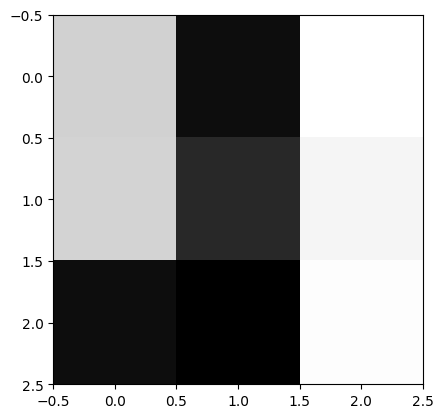

In [119]:
height,width = 3,3

image = np.array([
       [0.82,  0.1, 0.99],
       [0.83,  0.2, 0.95],
       [0.1,  0.05, 0.98]
       ])
plt.imshow(image, cmap=plt.cm.gray)

### Convert Image to Graph

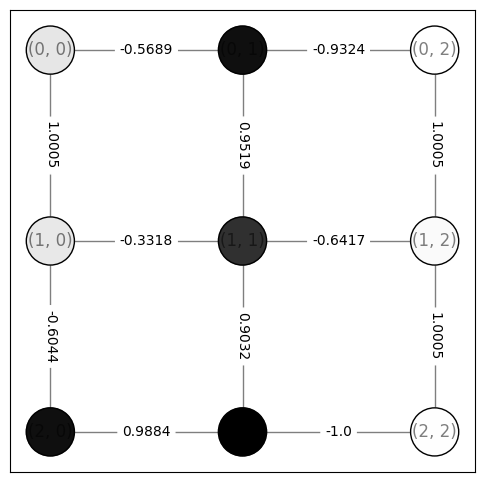

In [121]:
normalized_nx_elist = image_to_grid_graph(image)  # We are using Guassian similarity metric as the edge weight metric
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
draw(G, image)

### Solve using D-Wave annealer

In [134]:
start_time = time.time()
samples_dataframe, execution_info_dict = annealer_solver(G, private_token = 'jul-5215c8008132f206eba40344f90b0cfe8a586600')
total_time = time.time()-start_time
execution_info_dict['total_time'] = total_time
execution_info_dict

{'qpu_sampling_time': 222800.0,
 'qpu_anneal_time_per_sample': 20.0,
 'qpu_readout_time_per_sample': 70.86,
 'qpu_access_time': 238725.57,
 'qpu_access_overhead_time': 1191.43,
 'qpu_programming_time': 15925.57,
 'qpu_delay_time_per_sample': 20.54,
 'total_post_processing_time': 337.0,
 'post_processing_overhead_time': 337.0,
 'problem_formulation_time': 0.01840686798095703,
 'connection_time': 4.283363103866577,
 'embedding_time': 0.14559245109558105,
 'response_time': 0.08754682540893555,
 'sample_fetch_time': 0.0025017261505126953,
 'total_time': 6.373000144958496}

### All samples received

In [136]:
samples_dataframe

,0,1,2,3,4,5,6,7,8,chain_break_fraction,energy,num_occurrences
0,0,1,0,0,1,0,1,1,0,0.0,-4.0870,998
1,1,0,1,1,0,1,0,0,1,0.0,-4.0830,998
2,0,1,0,0,1,0,0,1,0,0.0,-2.4902,1
3,0,1,1,0,1,0,1,1,0,0.0,-2.1522,1
4,1,0,0,1,0,1,0,0,1,0.0,-2.1520,2


### Decode binary solution string to a binary segmentation mask

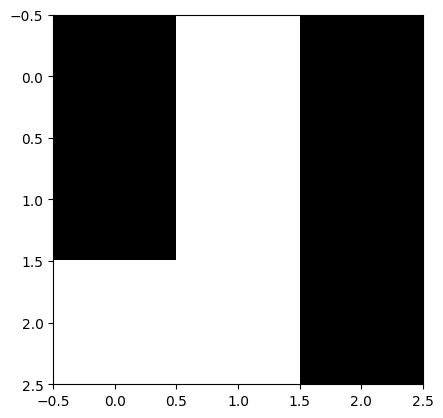

In [138]:
solution_binary_string = samples_dataframe.iloc[0][:-3]
segmentation_mask = decode_binary_string(solution_binary_string, height, width)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)